This notebook presents all the analysis reported in Study 6 of the paper.

Click the "Show Code" buttons to see the code associated with each output.

# Preamble

## Libraries

In [1]:
# Misc
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Markdown

# Data libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

sns.set_context("notebook")

#Statistics
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats.mstats import zscore
from statsmodels.stats.proportion import proportions_chisquare


# Interface with R
import rpy2
%load_ext rpy2.ipython


STUDY_NAME = "Study 6"

## Functions

In [2]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))


def plot_maxbonus_cdf(
    data,
    save=False,
    show=True,
    grayscale=False,
    figname=f"Fig 10 - {STUDY_NAME} - CDF Max Bonus",
):
    if grayscale:
        pal = sns.color_palette("Greys")[2::3]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette()[0:2]
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")
        
    xticks = np.arange(20, 70, 5)
    xticklabels = [f"{i:.0f}¢" for i in xticks]
    sns.set_style("ticks")
    kw = {"color": [pal[0], pal[1]]}
    g = sns.FacetGrid(
        hue="condition",
        data=data,
        aspect=1.5,
        height=6.38 / 1.5,
        hue_order=["Equal dispersion", "Higher dispersion"],
        hue_kws=kw,
    )
    g.map(
        plt.hist,
        "memory_max_recoded",
        histtype="step",
        cumulative=True,
        density=True,
        bins=np.arange(30, 100, 2),
        lw=2,
    )
    g.set_xlabels("Reported Maximum Bonus")
    g.set_ylabels("Cumulative Proportion of Participants")

    g.ax.axvline(40, lw=1, color="grey", ls="-")
    g.ax.axvline(40, lw=1, color=pal[0], ls="--")
    g.ax.axvline(50, lw=1, color=pal[1], ls="--")
    g.ax.set_ylim(0, 1.1)
    g.ax.set_xlim(20, 65)
    g.ax.set_xticks(xticks)
    g.ax.set_xticklabels(xticklabels)

    legend_elements = [
        Line2D([0], [0], color="grey", ls="--", lw=2, label=f"True Max of Manipulated"),
        Line2D([0], [0], color=pal[0], lw=4, label="Equal (SD = 4)"),
        Line2D([0], [0], color="grey", ls="-", lw=1, label=f"True Max of Common"),
        Line2D([0], [0], color=pal[1], lw=4, label="Higher (SD = 9)"),
    ]

    g.ax.legend(
        handles=legend_elements,
        loc="center",
        ncol=2,
        frameon=True,
        bbox_to_anchor=(0.5, -0.25),
    )
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()


def plot_search_length(
    data,
    save=False,
    show=True,
    grayscale=False,
    figname=f"Fig 11 - {STUDY_NAME} - Search Length",
):
    if grayscale:
        pal = sns.color_palette("Greys")[2::3]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette()[0:2]
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")
        
    kw = {"color": [pal[0], pal[1]], "linestyle": ["-", "--"]}

    boxes = [30, 38, 26, 20, 32]
    bonus_to_box = {i + 1: f"{v:.0f}¢" for i, v in enumerate(boxes)}

    g = sns.FacetGrid(
        hue="condition",
        data=data,
        aspect=2,
        height=4,
        hue_kws=kw,
        hue_order=["Equal dispersion", "Higher dispersion"],
    )
    g.map(
        plt.hist,
        "box_opened",
        bins=np.arange(0.5, 6.5, 1),
        histtype="step",
        density=True,
        lw=2,
    )
    plt.legend(
        title="Manipulated category had...",
        loc=1,
        bbox_to_anchor=(1.01, 1.025),
        facecolor="white",
        frameon=True,
        framealpha=1,
        edgecolor="white",
    )
    g.ax.set_ylim(0, 0.7)
    g.set_xlabels("\nBox Chosen")
    g.set_ylabels("Proportion of Participants")
    g.ax.set_xticks([1, 2, 3, 4, 5])
    g.ax.set_xticklabels([f"Box {k}\n({v})" for k, v in bonus_to_box.items()])
    for ax in g.axes.flatten():
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=True
        )
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()


def format_pvals(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

## Data loading

In [3]:
df = pd.read_csv(f"../Data/{STUDY_NAME}/CleanData.csv")

# Data Description

## Raw Data

In [4]:
Markdown(f"Number of observations collected: {df.shape[0]}. Pre-registered target: 500.")

Number of observations collected: 502. Pre-registered target: 500.

## Bonus Amounts Entered in Dollars (rather than cents)

In [5]:
n_bonus_dollars = (df.memory_max != df.memory_max_recoded).sum()
Markdown(f"""{n_bonus_dollars} participants in our data entered a memory for the bonus amount that was smaller than 1.
         We assume that those participants entered the bonus amount in dollars rather than in cents 
         (i.e., a value of 0.42 for a bonus of 42 cents), and recoded those values accordingly.""")

48 participants in our data entered a memory for the bonus amount that was smaller than 1.
         We assume that those participants entered the bonus amount in dollars rather than in cents 
         (i.e., a value of 0.42 for a bonus of 42 cents), and recoded those values accordingly.

## Exclusions

Following the pre-registration, we excluded all the participants who reported a maximum value strictly lower than the median value in the distributions (i.e., 32).

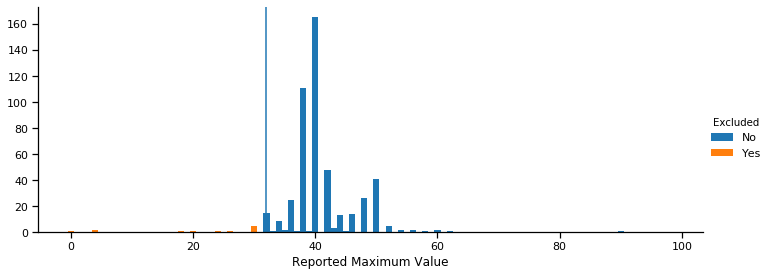

In [6]:
g = sns.FacetGrid(data=df, hue="excluded_if_recoded", height=4, aspect=2.5)
g.map(plt.hist, "memory_max_recoded", bins=np.arange(0, 100, 1) - 0.5)
g.add_legend(title="Excluded")
g.set_xlabels("Reported Maximum Value")
g.ax.axvline(32);

In [7]:
df_clean = df[df.excluded_if_recoded == "No"]
n_excluded = df.shape[0] - df_clean.shape[0]
Markdown(
    f"{n_excluded} participants excluded. Final number of observations after exclusion: {df_clean.shape[0]}"
)

12 participants excluded. Final number of observations after exclusion: 490

# Main Analysis

## Memory for the maximum bonus

The CDF of the responses shows the following:

* In the "Equal dispersion" condition, participants are unlikely to exceed the true maximum value (40).
* In the "Higher dispersion" condition, participants often exceed the true maximum value.

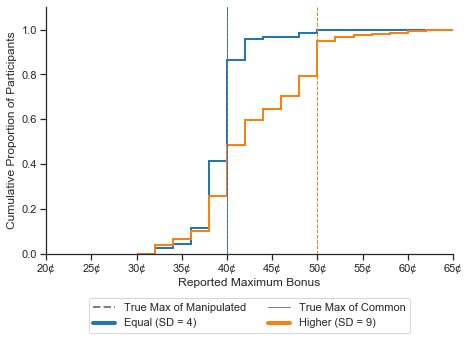

In [8]:
plot_maxbonus_cdf(df_clean, grayscale=True, save=True, show=False)
plot_maxbonus_cdf(df_clean, save=True, show=True)

We analyzed this difference using an OLS regression:

In [9]:
%%R -i df_clean -o coeffs
library(tidyverse)
df_clean$box_opened <- df_clean$box_opened %>% as.factor
df_clean$label_category <- df_clean$label_category %>% as.factor %>% relevel(ref="Blue")
df_clean$condition <- df_clean$condition %>% as.factor %>% relevel(ref="Equal dispersion")
contrasts(df_clean$label_category) <- contr.sum
summ <- summary(lm("memory_max_recoded ~ condition*label_category", df_clean))
coeffs <- summ$coefficients %>% as.data.frame

coeffs[["Standardized Betas"]] <- coeffs[["Estimate"]] / sd(df_clean$memory_max)

coeffs[["Predictor"]] <- c("Intercept",
                          "Non-Focal has higher dispersion", 
                          "Label of Focal (Sum-Contrast)", 
                          "Interaction Term")

In [10]:
coeffs.set_index("Predictor")

,Estimate,Std. Error,t value,Pr(>|t|),Standardized Betas
Predictor,,,,,
Intercept,39.375126,0.321841,122.343256,0.000000e+00,3.053597
Non-Focal has higher dispersion,3.677719,0.454158,8.097885,4.539704e-15,0.285212
Label of Focal (Sum-Contrast),0.255126,0.321841,0.792707,4.283351e-01,0.019785
Interaction Term,-0.429923,0.454158,-0.946637,3.442942e-01,-0.033341


In [11]:
Markdown(
    f"As predicted, only the variance of the non-focal distribution exerts a significant \
influence: b = {coeffs.iloc[1, 0]:.3f}, p < .001. \n\nNeither the counterbalancing factor nor \
its interaction are significant at a .05 level."
)

As predicted, only the variance of the non-focal distribution exerts a significant influence: b = 3.678, p < .001. 

Neither the counterbalancing factor nor its interaction are significant at a .05 level.

In [12]:
df_clean["above_actual_max"] = (df_clean.memory_max_recoded > 40) * 1

nobs = df_clean.groupby("condition").above_actual_max.count()
nsuc = df_clean.groupby("condition").above_actual_max.sum()
props = nsuc / nobs * 100
chi, p = proportions_chisquare(nsuc[[0, 1]], nobs[[0, 1]])[0:2]
Markdown(
    f"""Proportion above actual max: {props[0]:.0f}% vs. {props[1]:.0f}%: $\chi$(1) = {chi:.2f}, {format_pvals(p)}; 
"""
)

Proportion above actual max: 14% vs. 52%: $\chi$(1) = 80.87, p < .001; 


## Number of boxes opened

The second variable is the number of boxes opened by participants. 

As predicted, participants in the "More variance" condition opened more boxes. 

The histogram below summarizes the number of boxes opened by participants, as a function of their experimental condition. 

In [13]:
table = (
    df_clean.groupby(["condition", "box_opened"])[["bonusamount"]].count()
    / df_clean.groupby("condition")[["bonusamount"]].count()
    * 100
)
table.index.names = ["Condition", "Box Opened"]
table.columns = ["Proportion by condition"]
table.style.format("{:.0f}%")

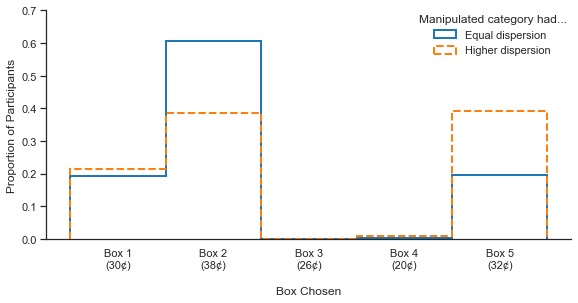

In [14]:
plot_search_length(df_clean, show=True, save=True)
plot_search_length(df_clean, grayscale=True, show=False, save=True)

As reported in the pre-registration, we tested the significance of this difference using an Ordered Logit model. 

This approach models a latent utility space divided in K thresholds, delineating the preference between opening K and K+1 boxes. 

In addition, this model estimates the impact of our predictors in the latent utility space: a positive coefficient means a preference for opening more boxes.

Given that no participant chose the third box, the threshold between the second and third box and the threshold between the third and fourth box form a single threshold.

In [15]:
%%R -i df_clean -o coeffs
library(tidyverse)
library(MASS)
df_clean$box_opened <- df_clean$box_opened %>% as.factor
df_clean$label_category <- df_clean$label_category %>% as.factor %>% relevel(ref="Blue")
df_clean$condition <- df_clean$condition %>% as.factor %>% relevel(ref="Equal dispersion")
contrasts(df_clean$label_category) <- contr.sum

summ <- summary(polr("box_opened ~ condition*label_category", df_clean, Hess=TRUE))

df_resid <- summ$df.residual
t_to_p <- function(t, df=1) {
    return(2*pt(-abs(t), df=df))
}
t_to_p_with_df <- partial(t_to_p, df=df_resid)

coeffs <- summ$coefficients %>% as.data.frame
coeffs[["Pr(>|t|)"]] <- coeffs[["t value"]] %>% purrr::map(t_to_p_with_df) %>% as.numeric
coeffs[["Odds Ratio"]] <-coeffs[["Value"]] %>% purrr::map(exp) %>% as.numeric
coeffs[4:6, "Odds Ratio"] <- c(NA, NA, NA)
coeffs[["Predictor"]] <- c("Non-Focal has Higher Variance (Dummy-Coded)", 
                          "Label of Focal (Sum-Contrast)", 
                          "Interaction Term", 
                          "Decision Threshold: Box 1 to Box 2", 
                          "Decision Threshold: Box 2 to Box 4", 
                          "Decision Threshold: Box 4 to Box 5")

In [16]:
coeffs.set_index("Predictor")

,Value,Std. Error,t value,Pr(>|t|),Odds Ratio
Predictor,,,,,
Non-Focal has Higher Variance (Dummy-Coded),0.517121,0.172852,2.991709,2.915785e-03,1.677193
Label of Focal (Sum-Contrast),0.025061,0.117527,0.213237,8.312323e-01,1.025378
Interaction Term,0.246608,0.171625,1.436902,1.513919e-01,1.279678
Decision Threshold: Box 1 to Box 2,-1.149589,0.133762,-8.594271,1.163772e-16,NaN
Decision Threshold: Box 2 to Box 4,1.105454,0.132801,8.324122,8.753890e-16,NaN
Decision Threshold: Box 4 to Box 5,1.136063,0.133478,8.511267,2.173980e-16,NaN


In [17]:
Markdown(
    f"As predicted, only the variance of the non-focal distribution had a significant \
influence: b = {coeffs.iloc[0, 0]:.3f}, p = {coeffs.iloc[0, 3]:.6f}, odds ratio = {coeffs.iloc[0, 4]:.3f}. \n\nNeither the counterbalancing factor nor \
its interaction are significant at a .05 level."
)

As predicted, only the variance of the non-focal distribution had a significant influence: b = 0.517, p = 0.002916, odds ratio = 1.677. 

Neither the counterbalancing factor nor its interaction are significant at a .05 level.

## Amount of money earned?

In [18]:
%%R -i df_clean -o coeffs
library(tidyverse)
df_clean$label_category <- df_clean$label_category %>% as.factor %>% relevel(ref="Blue")
df_clean$condition <- df_clean$condition %>% as.factor %>% relevel(ref="Equal dispersion")
contrasts(df_clean$label_category) <- contr.sum
summ <- summary(lm("bonusamountnumeric ~ condition*label_category", df_clean))
coeffs <- summ$coefficients %>% as.data.frame

coeffs[["Standardized Betas"]] <- coeffs[["Estimate"]] / sd(df_clean$bonusamountnumeric)

coeffs[["Predictor"]] <- c("Intercept",
                          "Non-Focal has Higher Variance (Dummy-Coded)", 
                          "Label of Focal (Sum-Contrast)", 
                          "Interaction Term")

In [19]:
coeffs.set_index("Predictor")

,Estimate,Std. Error,t value,Pr(>|t|),Standardized Betas
Predictor,,,,,
Intercept,35.204639,0.230243,152.901938,0.000000,9.631972
Non-Focal has Higher Variance (Dummy-Coded),-1.416021,0.324902,-4.358305,0.000016,-0.387423
Label of Focal (Sum-Contrast),-0.011361,0.230243,-0.049345,0.960665,-0.003108
Interaction Term,-0.118720,0.324902,-0.365403,0.714970,-0.032482


In [20]:
Markdown(
    f"As predicted, only the variance of the non-focal distribution exerts a significant \
influence: b = {coeffs.iloc[1, 0]:.3f}, p < .001. \n\nNeither the counterbalancing factor nor \
its interaction are significant at a .05 level."
)

As predicted, only the variance of the non-focal distribution exerts a significant influence: b = -1.416, p < .001. 

Neither the counterbalancing factor nor its interaction are significant at a .05 level.

# Robustness Check - Excluding Participants Who Answered in Dollars

In [21]:
df_clean = df[df.excluded == "No"]
n_excluded = df.shape[0] - df_clean.shape[0]
Markdown(
    f"{n_excluded} participants excluded. Observations after exclusion: {df_clean.shape[0]}"
)

57 participants excluded. Observations after exclusion: 445

## Memory for the maximum bonus

In [22]:
%%R -i df_clean -o coeffs
library(tidyverse)
df_clean$box_opened <- df_clean$box_opened %>% as.factor
df_clean$label_category <- df_clean$label_category %>% as.factor %>% relevel(ref="Blue")
df_clean$condition <- df_clean$condition %>% as.factor %>% relevel(ref="Equal dispersion")
contrasts(df_clean$label_category) <- contr.sum
summ <- summary(lm("memory_max_recoded ~ condition*label_category", df_clean))
coeffs <- summ$coefficients %>% as.data.frame

coeffs[["Standardized Betas"]] <- coeffs[["Estimate"]] / sd(df_clean$memory_max)

coeffs[["Predictor"]] <- c("Intercept",
                          "Non-Focal has higher dispersion", 
                          "Label of Focal (Sum-Contrast)", 
                          "Interaction Term")

In [23]:
coeffs.set_index("Predictor")

,Estimate,Std. Error,t value,Pr(>|t|),Standardized Betas
Predictor,,,,,
Intercept,39.240721,0.350290,112.023406,0.000000e+00,7.194339
Non-Focal has higher dispersion,3.840950,0.485933,7.904286,2.177687e-14,0.704194
Label of Focal (Sum-Contrast),0.151436,0.350290,0.432314,6.657242e-01,0.027764
Interaction Term,-0.285281,0.485933,-0.587080,5.574506e-01,-0.052303


In [24]:
Markdown(
    f"As predicted, only the variance of the non-focal distribution exerts a significant \
influence: b = {coeffs.iloc[1, 0]:.3f}, p < .001. \n\nNeither the counterbalancing factor nor \
its interaction are significant at a .05 level."
)

As predicted, only the variance of the non-focal distribution exerts a significant influence: b = 3.841, p < .001. 

Neither the counterbalancing factor nor its interaction are significant at a .05 level.

In [25]:
df_clean["above_actual_max"] = (df_clean.memory_max > 40) * 1

nobs = df_clean.groupby("condition").above_actual_max.count()
nsuc = df_clean.groupby("condition").above_actual_max.sum()
props = nsuc / nobs * 100
chi, p = proportions_chisquare(nsuc[[0, 1]], nobs[[0, 1]])[0:2]
Markdown(
    f"""Proportion above actual max: {props[0]:.0f}% vs. {props[1]:.0f}%: $\chi$(1) = {chi:.2f}, {format_pvals(p)}; 
"""
)

Proportion above actual max: 13% vs. 52%: $\chi$(1) = 79.13, p < .001; 


## Number of boxes opened

In [26]:
table = (
    df_clean.groupby(["condition", "box_opened"])[["bonusamount"]].count()
    / df_clean.groupby("condition")[["bonusamount"]].count()
    * 100
)
table.index.names = ["Condition", "Box Opened"]
table.columns = ["Proportion by condition"]
table.style.format("{:.0f}%")

As reported in the pre-registration, we tested the significance of this difference using an Ordered Logit model. 

This approach models a latent utility space divided in K thresholds, delineating the preference between opening K and K+1 boxes. 

In addition, this model estimates the impact of our predictors in the latent utility space: a positive coefficient means a preference for opening more boxes.

Given that no participant chose the third box, the threshold between the second and third box and the threshold between the third and fourth box form a single threshold.

In [27]:
%%R -i df_clean -o coeffs
library(tidyverse)
library(MASS)
df_clean$box_opened <- df_clean$box_opened %>% as.factor
df_clean$label_category <- df_clean$label_category %>% as.factor %>% relevel(ref="Blue")
df_clean$condition <- df_clean$condition %>% as.factor %>% relevel(ref="Equal dispersion")
contrasts(df_clean$label_category) <- contr.sum

summ <- summary(polr("box_opened ~ condition*label_category", df_clean, Hess=TRUE))

df_resid <- summ$df.residual
t_to_p <- function(t, df=1) {
    return(2*pt(-abs(t), df=df))
}
t_to_p_with_df <- partial(t_to_p, df=df_resid)

coeffs <- summ$coefficients %>% as.data.frame
coeffs[["Pr(>|t|)"]] <- coeffs[["t value"]] %>% purrr::map(t_to_p_with_df) %>% as.numeric
coeffs[["Odds Ratio"]] <-coeffs[["Value"]] %>% purrr::map(exp) %>% as.numeric
coeffs[4:6, "Odds Ratio"] <- c(NA, NA, NA)
coeffs[["Predictor"]] <- c("Non-Focal has Higher Variance (Dummy-Coded)", 
                          "Label of Focal (Sum-Contrast)", 
                          "Interaction Term", 
                          "Decision Threshold: Box 1 to Box 2", 
                          "Decision Threshold: Box 2 to Box 4", 
                          "Decision Threshold: Box 4 to Box 5")

In [28]:
coeffs.set_index("Predictor")

,Value,Std. Error,t value,Pr(>|t|),Odds Ratio
Predictor,,,,,
Non-Focal has Higher Variance (Dummy-Coded),0.535505,0.180570,2.965642,3.185253e-03,1.708310
Label of Focal (Sum-Contrast),0.027545,0.125515,0.219460,8.263937e-01,1.027928
Interaction Term,0.306287,0.179417,1.707130,8.850494e-02,1.358373
Decision Threshold: Box 1 to Box 2,-1.093502,0.141358,-7.735697,7.116486e-14,NaN
Decision Threshold: Box 2 to Box 4,1.089849,0.141310,7.712488,8.354402e-14,NaN
Decision Threshold: Box 4 to Box 5,1.123247,0.142045,7.907671,2.145117e-14,NaN


In [29]:
Markdown(
    f"As predicted, only the variance of the non-focal distribution had a significant \
influence: b = {coeffs.iloc[0, 0]:.3f}, p = {coeffs.iloc[0, 3]:.6f}, odds ratio = {coeffs.iloc[0, 4]:.3f}. \n\nNeither the counterbalancing factor nor \
its interaction are significant at a .05 level."
)

As predicted, only the variance of the non-focal distribution had a significant influence: b = 0.536, p = 0.003185, odds ratio = 1.708. 

Neither the counterbalancing factor nor its interaction are significant at a .05 level.

## Amount of money earned?

In [30]:
%%R -i df_clean -o coeffs
library(tidyverse)
df_clean$label_category <- df_clean$label_category %>% as.factor %>% relevel(ref="Blue")
df_clean$condition <- df_clean$condition %>% as.factor %>% relevel(ref="Equal dispersion")
contrasts(df_clean$label_category) <- contr.sum
summ <- summary(lm("bonusamountnumeric ~ condition*label_category", df_clean))
coeffs <- summ$coefficients %>% as.data.frame

coeffs[["Standardized Betas"]] <- coeffs[["Estimate"]] / sd(df_clean$bonusamountnumeric)

coeffs[["Predictor"]] <- c("Intercept",
                          "Non-Focal has Higher Variance (Dummy-Coded)", 
                          "Label of Focal (Sum-Contrast)", 
                          "Interaction Term")

In [31]:
coeffs.set_index("Predictor")

,Estimate,Std. Error,t value,Pr(>|t|),Standardized Betas
Predictor,,,,,
Intercept,35.002626,0.248700,140.742202,0.000000,9.532031
Non-Focal has Higher Variance (Dummy-Coded),-1.193706,0.345004,-3.459976,0.000593,-0.325074
Label of Focal (Sum-Contrast),0.056197,0.248700,0.225965,0.821334,0.015304
Interaction Term,-0.195553,0.345004,-0.566813,0.571129,-0.053254


In [32]:
Markdown(
    f"As predicted, only the variance of the non-focal distribution exerts a significant \
influence: b = {coeffs.iloc[1, 0]:.3f}, p < .001. \n\nNeither the counterbalancing factor nor \
its interaction are significant at a .05 level."
)

As predicted, only the variance of the non-focal distribution exerts a significant influence: b = -1.194, p < .001. 

Neither the counterbalancing factor nor its interaction are significant at a .05 level.